# Distributed Clustering Testing

## Imports and basic functions

#### Imports libs needed and created function to get available GPUs and to make training data

In [1]:
import matplotlib.pyplot as plt

import os
import time

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib

from sklearn.datasets import make_classification

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def make_data(filepath, n_obs, n_dim, seed, K):

    try:
        os.remove(filepath)
    except:
        print('file not found')
    finally:
        (X, Y) = make_classification(n_samples            = n_obs    , 
                                     n_features           = n_dim    ,
                                     n_informative        = n_dim    ,
                                     n_redundant          = 0        ,
                                     n_classes            = K        ,
                                     n_clusters_per_class = 1        ,
                                     shuffle              = True     ,
                                     class_sep            = 1.5      ,
                                     random_state         = seed     )
        
        np.savez(filepath, X=X, Y=Y)

    return True

/home/lopac/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Creates a Tensorflow InteractiveSession

An InteractiveSession is used to "debug" the code. It allows you to see what's happening. On production code, use Session instead.

In [2]:
# config = tf.ConfigProto( allow_soft_placement = True )
# config.gpu_options.allow_growth = True
# config.gpu_options.allocator_type = 'BFC'

# sess = tf.InteractiveSession( config = config )

#### Defining variables used throughout the code

In [16]:
n_obs = 500000000
n_dim = 2
K     = 3
GPU_names = get_available_gpus()
n_max_iters = 20
seed = 800594

In [17]:
make_data('test-data.npz', n_obs, n_dim, seed, K)

True

In [5]:
data = np.load('test-data.npz')

data_X = data['X']
data_Y = data['Y']
initial_centers = data_X[0:K, :]

#### Make data batches

In [6]:
data_size = n_dim * n_obs * data_X.dtype.itemsize

if (len(GPU_names) == 8):
    max_size = 134217728 * 2 * data_X.dtype.itemsize
elif (len(GPU_names) == 6):
    max_size = 16777216 * 16 * data_X.dtype.itemsize
elif (len(GPU_names) == 4):
    max_size = 16777216 * 11 * data_X.dtype.itemsize
elif (len(GPU_names) == 2):
    max_size = 8388608 * 11 * data_X.dtype.itemsize

num_batches = np.ceil(data_size / max_size)

batches = np.array_split(data_X, num_batches)

print(batches[0].shape)

(125000000, 2)


In [7]:
GPU_names

['/device:GPU:0',
 '/device:GPU:1',
 '/device:GPU:2',
 '/device:GPU:3',
 '/device:GPU:4',
 '/device:GPU:5',
 '/device:GPU:6',
 '/device:GPU:7']

#### KMeans Function

In [8]:
def kmeansclustering(data_batch, GPU_names, K, initial_centers, n_max_iters):
    sizes = [len(arg) for arg in np.array_split( data_batch, len(GPU_names))]

    partial_directions = []
    partial_values = []
    partial_results = []
    
    tf.reset_default_graph()
    with tf.name_scope('global'):
        with tf.device('/cpu:0'):
            all_data = tf.placeholder(data_batch.dtype, shape=(data_batch.shape), name='all_data')
            parts = tf.split(all_data, sizes, 0)

            global_centroids = tf.Variable(initial_centers)
            
    for GPU_num in range(len(GPU_names)):
        GPU_name = GPU_names[GPU_num]

        (X_mat) = parts[GPU_num]
        (N, M) = X_mat.get_shape().as_list()

        with tf.name_scope('scope_' + str(GPU_num)):
            with tf.device(GPU_name) :
                ####
                # In the coments we denote :
                # => N = Number of Observations
                # => M = Number of Dimensions
                # => K = Number of Centers
                ####

                # Data for GPU GPU_num to Clusterize            
                X = tf.Variable(X_mat)

                # Reshapes rep_centroids and rep_points to format N x K x M so that 
                # the 2 matrixes have the same size
                rep_centroids = tf.reshape(tf.tile(global_centroids, [N, 1]), [N, K, M])
                rep_points = tf.reshape(tf.tile(X, [1, K]), [N, K, M])

                # Calculates sum_squares, a matrix of size N x K
                # This matrix is not sqrt((X-Y)^2), it is just(X-Y)^2
                # Since we need just the argmin(sqrt((X-Y)^2)) wich is equal to 
                # argmin((X-Y)^2), it would be a waste of computation
                sum_squares = tf.reduce_sum(tf.square(tf.subtract( rep_points, rep_centroids) ), axis = 2)

                # Use argmin to select the lowest-distance point
                # This gets a matrix of size N x 1
                best_centroids = tf.argmin(sum_squares, axis = 1)

                means = []
                for c in range(K):
                    means.append(
                        tf.reduce_mean(
                            tf.gather(X, tf.reshape(tf.where(tf.equal(best_centroids, c)), [1,-1])), axis=[1]))

                new_centroids = tf.concat(means, 0)
    #             print('GPU: ', GPU_name)
    #             print('Initial centers ', initial_centers)
    #             print('New centroids ', new_centroids.eval())

            with tf.device('/cpu:0'):
                y_count = tf.cast(
                    tf.bincount(tf.to_int32(best_centroids), maxlength = K, minlength = K), dtype = tf.float64)

                partial_mu =  tf.multiply( tf.transpose(new_centroids), y_count )

                partial_directions.append( y_count )
                partial_values.append( partial_mu )
                
    with tf.name_scope('global') :
        with tf.device('/cpu:0') :
            sum_direction = tf.add_n( partial_directions )
            sum_mu = tf.add_n( partial_values )

            rep_sum_direction = tf.reshape(tf.tile(sum_direction, [M]), [M, K])
            new_centers = tf.transpose( tf.div(sum_mu, rep_sum_direction) )

            update_centroid = tf.group( global_centroids.assign(new_centers) )
            
    config = tf.ConfigProto( allow_soft_placement = True )
    config.gpu_options.allow_growth = True
    config.gpu_options.allocator_type = 'BFC'

    init = tf.global_variables_initializer()

    with tf.Session(config = config) as sess:
        sess.run(init, feed_dict={all_data: data_batch})

        for i in range(n_max_iters):
            [result, _] = sess.run([global_centroids, update_centroid])
            
    return {"centers": result}

#### Fuzzy CMeans Function

In [9]:
def fuzzycmeansclustering(data_batch, GPU_names, K, initial_centers, n_max_iters):
    sizes = [len(arg) for arg in np.array_split( data_batch, len(GPU_names))]

    partial_Mu_sum_list = []
    partial_Mu_X_sum_list = []
    
    tf.reset_default_graph()
    with tf.name_scope('global'):
        with tf.device('/cpu:0'):
            all_data = tf.placeholder(data_batch.dtype, shape=(data_batch.shape), name='all_data')
            parts = tf.split(all_data, sizes, 0)

            global_centroids = tf.Variable(initial_centers)
            
    for GPU_num in range(len(GPU_names)):
        GPU_name = GPU_names[GPU_num]

        (X_mat) = parts[GPU_num]
        (N, M) = X_mat.get_shape().as_list()

        with tf.name_scope('scope_' + str(GPU_num)):
            with tf.device(GPU_name) :
                ####
                # In the coments we denote :
                # => N = Number of Observations
                # => M = Number of Dimensions
                # => K = Number of Centers
                ####
                # Data for GPU GPU_num to Clusterize
                X = tf.Variable(X_mat)

                # Reshapes rep_centroids and  rep_points to format N x K x M so that 
                # the 2 matrixes have the same size
                rep_centroids = tf.reshape(tf.tile(global_centroids, [N, 1]), [N, K, M])
                rep_points = tf.reshape(tf.tile(X, [1, K]), [N, K, M])

                # Calculates sum_squares, a matrix of size N x K
                # This matrix is just(X-Y)^2
                dist_to_centers = tf.sqrt( tf.reduce_sum(tf.square(tf.subtract( rep_points, rep_centroids) ), 
                                                         reduction_indices = 2) )
                
                # Calculates cluster_membership, a matrix of size N x K
                tmp = tf.pow(dist_to_centers, -2 / (M - 1))
                cluster_membership_with_nan = tf.div( tf.transpose(tmp), tf.reduce_sum(tmp, 1))
                
                # Error treatment for when there are zeros in count_means_aux
                cluster_membership = tf.where(
                    tf.is_nan(cluster_membership_with_nan), tf.zeros_like(cluster_membership_with_nan), cluster_membership_with_nan);
                
                MU = tf.pow(cluster_membership, M)
                
                # Calculates auxiliar matrixes 
                # Mu_X_sum of size 
                Mu_X_sum = tf.matmul(MU, X)
                Mu_sum = tf.reduce_sum(MU, 1)
                
                partial_Mu_sum_list.append( Mu_sum )
                partial_Mu_X_sum_list.append( Mu_X_sum )
                
    with tf.name_scope('global') :
        with tf.device('/cpu:0') :
            global_Mu_sum = tf.add_n( partial_Mu_sum_list )
            global_Mu_X_sum = tf.transpose(  tf.add_n(partial_Mu_X_sum_list) )
            
            new_centers = tf.transpose( tf.div(global_Mu_X_sum, global_Mu_sum) )
            
            update_centroid = tf.group( global_centroids.assign(new_centers) )
            
    config = tf.ConfigProto( allow_soft_placement = True )
    config.gpu_options.allow_growth = True
    config.gpu_options.allocator_type = 'BFC'

    init = tf.global_variables_initializer()

    with tf.Session(config = config) as sess:
        sess.run(init, feed_dict={all_data: data_batch})

        for i in range(n_max_iters):
            [result, _] = sess.run([global_centroids, update_centroid])
            
    return {"centers": result}

In [10]:
final_result_kmeans = []
final_result_fcmeans = []

for batch in batches:
    result = kmeansclustering(batch, GPU_names, K, initial_centers, n_max_iters)
    final_result_kmeans.append(result['centers'])
    print("deu 1")
    
for batch in batches:
    result = fuzzycmeansclustering(batch, GPU_names, K, initial_centers, n_max_iters)
    final_result_fcmeans.append(result['centers'])
    print("deu 2")
    

deu 1
deu 1
deu 1
deu 1
deu 2
deu 2
deu 2
deu 2


In [11]:
# new_centers = np.transpose(np.add.reduce(final_points) / np.add.reduce(final_values))
new_centers_kmeans = np.mean(final_result_kmeans, axis=0)
new_centers_fcmeans = np.mean(final_result_fcmeans, axis=0)

### Plotting graphs to evaluate results

#### Initial centroids

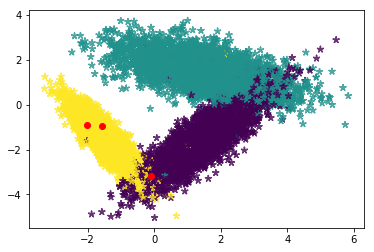

In [12]:
plt.scatter(data_X[0:np.min([data_X.shape[0], 10000]), 0], 
            data_X[0:np.min([data_X.shape[0], 10000]), 1], 
            c = data_Y[0:np.min([data_X.shape[0], 10000])],
            alpha = 0.8, marker = (5, 2))
plt.scatter(initial_centers[:, 0], initial_centers[:, 1], alpha = 1, c = 'red', marker = (5, 3))
plt.show()

#### After computation

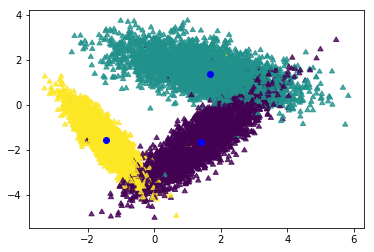

In [13]:
plt.scatter(data_X[0:np.min([data_X.shape[0], 10000]), 0], 
            data_X[0:np.min([data_X.shape[0], 10000]), 1], 
            c = data_Y[0:np.min([data_X.shape[0], 10000])],
            alpha = 0.8, marker = (3, 1))
plt.scatter(new_centers_kmeans[:, 0], new_centers_kmeans[:, 1], alpha = 1, c = 'blue', marker = (5, 3))
plt.show()

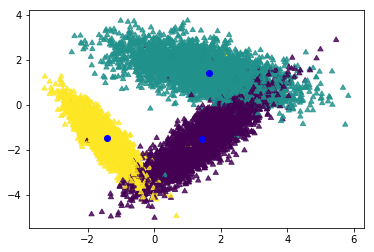

In [14]:
plt.scatter(data_X[0:np.min([data_X.shape[0], 10000]), 0], 
            data_X[0:np.min([data_X.shape[0], 10000]), 1], 
            c = data_Y[0:np.min([data_X.shape[0], 10000])],
            alpha = 0.8, marker = (3, 1))
plt.scatter(new_centers_fcmeans[:, 0], new_centers_fcmeans[:, 1], alpha = 1, c = 'blue', marker = (5, 3))
plt.show()